In [2]:
import pandas as pd
import pulp
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_customers = pd.read_csv('customers.csv')
df_customers

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [4]:
df_visit = pd.read_csv('visit_probability.csv')
df_visit

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


In [5]:
dict_seg_num = pd.merge(df_customers, df_visit).groupby('segment_id')['customer_id'].count().to_dict()
df_val = df_visit.copy()
df_val['seg_customer_num'] = df_val.segment_id.map(dict_seg_num)

In [6]:
for i in range(3):
    ptn = i + 1
    df_val[f'diff_dm{ptn}'] = df_val[f'prob_dm{ptn}'] - df_val.prob_dm1
    df_val[f'val_dm{ptn}'] = [pulp.LpVariable(f'x_{i}_{ptn}',lowBound=0, upBound=1, cat='Continuous') for i in df_val.segment_id]
dict_cost = {1:0, 2:1000, 3:2000}

In [7]:
df_val

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3,seg_customer_num,diff_dm1,val_dm1,diff_dm2,val_dm2,diff_dm3,val_dm3
0,age~19,freq0,1,0.07,0.12,0.29,200,0.0,x_1_1,0.05,x_1_2,0.22,x_1_3
1,age~19,freq1,2,0.21,0.30,0.58,150,0.0,x_2_1,0.09,x_2_2,0.37,x_2_3
2,age~19,freq2,3,0.28,0.39,0.74,50,0.0,x_3_1,0.11,x_3_2,0.46,x_3_3
3,age~19,freq3~,4,0.35,0.45,0.77,100,0.0,x_4_1,0.10,x_4_2,0.42,x_4_3
4,age20~34,freq0,5,0.11,0.17,0.37,600,0.0,x_5_1,0.06,x_5_2,0.26,x_5_3
5,age20~34,freq1,6,0.32,0.43,0.72,450,0.0,x_6_1,0.11,x_6_2,0.40,x_6_3
6,age20~34,freq2,7,0.42,0.55,0.93,150,0.0,x_7_1,0.13,x_7_2,0.51,x_7_3
7,age20~34,freq3~,8,0.52,0.63,0.94,300,0.0,x_8_1,0.11,x_8_2,0.42,x_8_3
8,age35~49,freq0,9,0.08,0.14,0.33,800,0.0,x_9_1,0.06,x_9_2,0.25,x_9_3
9,age35~49,freq1,10,0.25,0.35,0.67,600,0.0,x_10_1,0.10,x_10_2,0.42,x_10_3


In [8]:
problem = pulp.LpProblem('coupon3', pulp.LpMaximize)

y = pulp.LpVariable('y', lowBound=0, upBound=1, cat='Continuous')

# problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'diff_dm{m}'] * r.seg_customer_num 
#                        for m in [2,3] for _,r in df_val.iterrows()])

problem += y

for _, r in df_val.iterrows():
    problem += pulp.lpSum([r[f'val_dm{m}'] for m in [1,2,3]]) == 1
    for m in [1,2,3]:
        problem += r[f'val_dm{m}'] >= y

problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'prob_dm{m}'] * r.seg_customer_num * dict_cost[m] 
                       for m in [2,3] for _,r in df_val.iterrows()]) <= 10**6



In [9]:
import time
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'status:{pulp.LpStatus[status]}')
print(f'goal function value:{pulp.value(problem.objective):.4}')
print(f'calc time:{(time_stop - time_start)} second')

status:Optimal
goal function value:0.1313
calc time:0.028183460235595703 second


In [10]:
for m in [1,2,3]:
    df_val[f'result_dm{m}'] = df_val[f'val_dm{m}'].apply(lambda x: x.value())
    df_val[f'result_num_dm{m}'] = df_val[f'result_dm{m}'] * df_val.seg_customer_num
    df_val[f'result_prob_num_dm{m}'] = df_val[f'prob_dm{m}'] * df_val[f'result_dm{m}'] * df_val.seg_customer_num

In [11]:
df_val

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3,seg_customer_num,diff_dm1,val_dm1,diff_dm2,...,val_dm3,result_dm1,result_num_dm1,result_prob_num_dm1,result_dm2,result_num_dm2,result_prob_num_dm2,result_dm3,result_num_dm3,result_prob_num_dm3
0,age~19,freq0,1,0.07,0.12,0.29,200,0.0,x_1_1,0.05,...,x_1_3,0.737481,147.496226,10.324736,0.131259,26.251886,3.150226,0.131259,26.251886,7.613047
1,age~19,freq1,2,0.21,0.30,0.58,150,0.0,x_2_1,0.09,...,x_2_3,0.737481,110.622170,23.230656,0.131259,19.688915,5.906674,0.131259,19.688915,11.419570
2,age~19,freq2,3,0.28,0.39,0.74,50,0.0,x_3_1,0.11,...,x_3_3,0.737481,36.874057,10.324736,0.131259,6.562972,2.559559,0.131259,6.562972,4.856599
3,age~19,freq3~,4,0.35,0.45,0.77,100,0.0,x_4_1,0.10,...,x_4_3,0.737481,73.748113,25.811840,0.131259,13.125943,5.906674,0.131259,13.125943,10.106976
4,age20~34,freq0,5,0.11,0.17,0.37,600,0.0,x_5_1,0.06,...,x_5_3,0.737481,442.488678,48.673755,0.131259,78.755658,13.388462,0.131259,78.755658,29.139593
5,age20~34,freq1,6,0.32,0.43,0.72,450,0.0,x_6_1,0.11,...,x_6_3,0.737481,331.866509,106.197283,0.131259,59.066744,25.398700,0.131259,59.066744,42.528055
6,age20~34,freq2,7,0.42,0.55,0.93,150,0.0,x_7_1,0.13,...,x_7_3,0.737481,110.622170,46.461311,0.131259,19.688915,10.828903,0.131259,19.688915,18.310690
7,age20~34,freq3~,8,0.52,0.63,0.94,300,0.0,x_8_1,0.11,...,x_8_3,0.737481,221.244339,115.047056,0.131259,39.377829,24.808032,0.131259,39.377829,37.015159
8,age35~49,freq0,9,0.08,0.14,0.33,800,0.0,x_9_1,0.06,...,x_9_3,0.737481,589.984904,47.198792,0.131259,105.007544,14.701056,0.131259,105.007544,34.652490
9,age35~49,freq1,10,0.25,0.35,0.67,600,0.0,x_10_1,0.10,...,x_10_3,0.737481,442.488678,110.622170,0.131259,78.755658,27.564480,0.131259,78.755658,52.766291


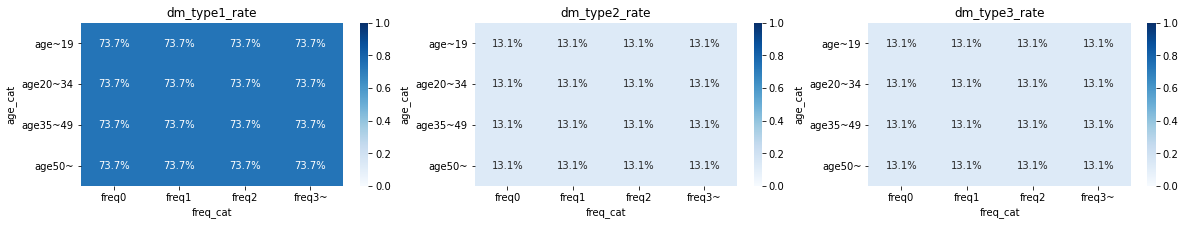

In [12]:
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3,figsize=(20,3))
for i in range(3):
    ptn = i+1
    df_pivot_tmp = pd.pivot_table(data=df_val, values=f'result_dm{ptn}', columns='freq_cat', index='age_cat', aggfunc='mean')
    df_pivot_tmp = df_pivot_tmp.reindex([f'age{x}' for x in ['~19', '20~34', '35~49', '50~']])
    sns.heatmap(df_pivot_tmp, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f'dm_type{ptn}_rate')
plt.show()

In [16]:
max_lowerbound = pulp.value(problem.objective)
max_lowerbound

0.13125943

In [17]:
problem = pulp.LpProblem('coupon3', pulp.LpMaximize)

problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'diff_dm{m}'] * r.seg_customer_num 
                       for m in [2,3] for _,r in df_val.iterrows()])

for _, r in df_val.iterrows():
    problem += pulp.lpSum([r[f'val_dm{m}'] for m in [1,2,3]]) == 1
    for m in [1,2,3]:
        problem += r[f'val_dm{m}'] >= max_lowerbound

problem += pulp.lpSum([r[f'val_dm{m}'] * r[f'prob_dm{m}'] * r.seg_customer_num * dict_cost[m] 
                       for m in [2,3] for _,r in df_val.iterrows()]) <= 10**6




In [19]:
import time
time_start = time.time()
status = problem.solve()
time_stop = time.time()
print(f'status:{pulp.LpStatus[status]}')
print(f'goal function value:{pulp.value(problem.objective):.4}')
print(f'calc time:{(time_stop - time_start)} second')

status:Optimal
goal function value:300.6
calc time:0.027614831924438477 second
